##  This notebook is specifically for the datasets with NO detailed job description.
Every night at 1am
Scrape data from Indeed to create 3 csv datasets based on:
'data science data scientist' 
'data analyst data analytics'
'machine learning'

In [2895]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from library.sb_utils import save_file

today = datetime.today().strftime('%Y_%m_%d')
dfNames=['da','ds','ml','ai']

list_of_df = []
data = pd.DataFrame()


for n in dfNames:
    fileName = '../data/raw/{0}_last{1}d_R_{2}.csv'.format(n,'1', today)
    df = pd.read_csv(fileName, skiprows=[0])
    print(df.shape)
    
    #will be deleted after first couple of trials
    list_of_df.append(df)
    
    #combine 3 files together
    data = data.append(df, ignore_index=True)
    print(data.shape)


(304, 13)
(304, 13)
(819, 13)
(1123, 13)
(924, 13)
(2047, 13)
(556, 13)
(2603, 13)


In [2896]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   JobID           2603 non-null   object 
 1   JobTitle        2603 non-null   object 
 2   Company         2603 non-null   object 
 3   Location        2603 non-null   object 
 4   CompanyRating   2046 non-null   float64
 5   PostDate        2603 non-null   object 
 6   ExtractDate     2603 non-null   object 
 7   Summary         2603 non-null   object 
 8   Salary          174 non-null    object 
 9   Remote          338 non-null    object 
 10  JobUrl          2603 non-null   object 
 11  JobDetail       144 non-null    object 
 12  JobDescription  477 non-null    object 
dtypes: float64(1), object(12)
memory usage: 264.5+ KB


In [2897]:
# To confirm the necessity of the step of de-duping the combined daily file. 
id_0 = set(list_of_df[0].JobID)
id_1 = set(list_of_df[1].JobID)
id_2 = set(list_of_df[2].JobID)
id_3 = set(list_of_df[3].JobID)

In [2898]:
print(len(id_0.intersection(id_1)))
print(len(id_0.intersection(id_2)))
print(len(id_0.intersection(id_3)))
print(len(id_1.intersection(id_2)))
print(len(id_1.intersection(id_3)))
print(len(id_2.intersection(id_3)))

37
18
4
231
64
179


### Step 2: De - duplicate records with same JobID
There are overlaps betweem 4 datasets


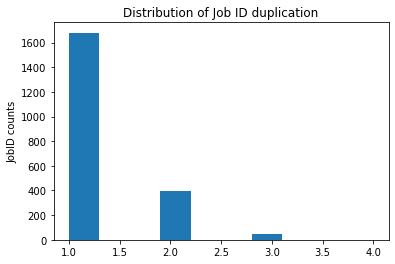

In [2899]:
data.JobID.value_counts().plot(kind='hist')
plt.title('Distribution of Job ID duplication')
plt.ylabel('JobID counts')
plt.xlabel('')
plt.show()

In [2900]:
#Group by column having count > 1 
#data.groupby('JobID').filter(lambda x: len(x) >1 ).sort_values('JobID')

In [2901]:
data.JobID.describe()

count                 2603
unique                2118
top       0feeaa7d0b7fc783
freq                     4
Name: JobID, dtype: object

In [2902]:
data.duplicated(subset ='JobID').sum()

485

In [2903]:
# To de-dup the records in the combined file
data.drop_duplicates(subset = 'JobID', inplace= True)
data.JobID.describe()

count                 2118
unique                2118
top       250fa093cbff7d5c
freq                     1
Name: JobID, dtype: object

In [2904]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2118 entries, 0 to 2601
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   JobID           2118 non-null   object 
 1   JobTitle        2118 non-null   object 
 2   Company         2118 non-null   object 
 3   Location        2118 non-null   object 
 4   CompanyRating   1629 non-null   float64
 5   PostDate        2118 non-null   object 
 6   ExtractDate     2118 non-null   object 
 7   Summary         2118 non-null   object 
 8   Salary          144 non-null    object 
 9   Remote          293 non-null    object 
 10  JobUrl          2118 non-null   object 
 11  JobDetail       111 non-null    object 
 12  JobDescription  398 non-null    object 
dtypes: float64(1), object(12)
memory usage: 231.7+ KB


In [2905]:
# To reindex 
data.index = np.arange(0,len(data))

### Step 3: Create a new variable 'DatePosted' as the exact date of job posted

In [2906]:
data.PostDate.unique()

array(['Today', 'Just posted', '1 day ago'], dtype=object)

In [2907]:
data.PostDate.str.contains('ago').sum()

248

In [2908]:
'|'.join(['ago','day','days'])

'ago|day|days'

In [2909]:
# To create a new variable 'DatePosted' by remove the string from 'PostDate' and convert to int
data['DatePosted'] = data.PostDate.str.replace('day ago|days ago','').str.replace('Today|Just posted','0').str.strip().astype(int)

In [2910]:
data.DatePosted.unique()

array([0, 1])

In [2911]:
data.DatePosted.dtypes

dtype('int32')

In [2912]:
# To convert 'ExtractDate' to datetime type
data['ExtractDate'] = pd.to_datetime(data['ExtractDate'])

In [2913]:
# To Convert 'DatePosted' from int to timeDelta type and compute the exact date when the job was posted 
data.DatePosted = pd.to_timedelta(data.DatePosted, unit='D')
data.DatePosted = pd.to_datetime(data['ExtractDate'] - data['DatePosted'])


In [2914]:
data.loc[:,['PostDate','ExtractDate','DatePosted']]

,PostDate,ExtractDate,DatePosted
0,Today,2021-02-26,2021-02-26
1,Today,2021-02-26,2021-02-26
2,Today,2021-02-26,2021-02-26
3,Today,2021-02-26,2021-02-26
4,Just posted,2021-02-26,2021-02-26
...,...,...,...
2113,Today,2021-02-26,2021-02-26
2114,Today,2021-02-26,2021-02-26
2115,Today,2021-02-26,2021-02-26
2116,Today,2021-02-26,2021-02-26


### Step 4: Create a new variable 'isRemote' and assign boolean value based on varible 'Remote' OR 'Location'

In [2915]:
data.Remote.unique()

array(['Temporarily remote', nan, 'Remote'], dtype=object)

In [2916]:
data.Remote.describe()

count        293
unique         2
top       Remote
freq         226
Name: Remote, dtype: object

In [2917]:
# Work on the contingency table (pivot talbe) between Location and Remote
s_Location = data.Location.copy()
s_Location[s_Location != 'Remote'] = 'Others'
s_Location.describe()

count       2118
unique         2
top       Others
freq        1946
Name: Location, dtype: object

In [2918]:
s_Remote = data.Remote.copy()
s_Remote[s_Remote != 'Remote'] = 'Others'
s_Remote.describe()

pd.crosstab(s_Location, s_Remote)

Remote,Others,Remote
Location,,
Others,1720,226
Remote,172,0


In [2919]:
data.Remote.unique()

array(['Temporarily remote', nan, 'Remote'], dtype=object)

In [2920]:
# try to construct contingency table directly from dataframe using groupby
#[('Others' if (l!='Remote') else l, 'Others' if (r!='Remote') else r )   for l,r in data['Location','Remote']]  #.groupby(by =['Location', 'Remote']).agg('count')

In [2921]:
data.Location.str.contains('Remote').sum()

172

In [2922]:
(data.Location =='Remote').sum()

172

In [2923]:
# To assign the value of Remote to the variable 'Remote' if the value of location is 'Remote'
# It maynot be necessary since we not going to use varialbe 'Remote' later
#data.loc[data.Location.str.contains('Remote'),'Remote'] = 'Remote'

In [2924]:
# To create a new boolean variable 'isRemote' and assign Ture if varible 'Remote' OR 'Location' is Remote
data['isRemote'] = (data.Remote == 'Remote') | (data.Location =='Remote')
data.isRemote.describe()

count      2118
unique        2
top       False
freq       1720
Name: isRemote, dtype: object

### Step 5: Extract city, state information from Location, Create new variables 'City', ‘State', and 'Region' 


In [2925]:
data.Location.describe()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


count       2118
unique       489
top       Remote
freq         172
Name: Location, dtype: object

In [2926]:
# To create two new variables City and State
newDf = data.Location.str.split(pat =',',expand =True)
data['City'] = newDf[0]
data['State'] = newDf[1]

In [2927]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2118 entries, 0 to 2117
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   JobID           2118 non-null   object        
 1   JobTitle        2118 non-null   object        
 2   Company         2118 non-null   object        
 3   Location        2118 non-null   object        
 4   CompanyRating   1629 non-null   float64       
 5   PostDate        2118 non-null   object        
 6   ExtractDate     2118 non-null   datetime64[ns]
 7   Summary         2118 non-null   object        
 8   Salary          144 non-null    object        
 9   Remote          293 non-null    object        
 10  JobUrl          2118 non-null   object        
 11  JobDetail       111 non-null    object        
 12  JobDescription  398 non-null    object        
 13  DatePosted      2118 non-null   datetime64[ns]
 14  isRemote        2118 non-null   bool          
 15  City

In [2928]:
# To clean up values of City ???? whether to treat special case 'United States' as Remote as well????
data.loc[data.City == 'Remote', 'City'] = np.nan
data.loc[data.City == 'United States', 'City'] = np.nan

In [2929]:
assert data.City.str.contains('Remote|United States').any()  == False

In [2930]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [2931]:
data.loc[((data.State.isnull()) & (~data.City.isnull())), 'City']


72               Georgia
147           California
261               Oregon
274           California
300       New York State
              ...       
1919                Ohio
1920            Colorado
1946    Washington State
1956                Ohio
1998        Pennsylvania
Name: City, Length: 92, dtype: object

In [2932]:
# To fill the missing value of 'State' from 'City' for those which has only location of State 
data.State.fillna(data.City, inplace=True)

In [2933]:
# To clean up values in 'City'
data.loc[data.State == data.City, 'City'] = np.nan

In [2934]:
data.State.unique()

array([' CA', ' FL', ' TX', ' WA', ' NY', nan, ' MA', ' NJ', ' HI', ' VA',
       ' DE', ' PA', ' DC', ' MD', ' OK', ' RI', ' AR', ' CO', ' AZ',
       ' CT', ' OH', ' NH', ' IA', ' ID', ' NM', ' UT', ' TN', ' GA',
       ' WV', 'Georgia', ' NV', ' NC', ' AL', ' MN', ' OR', ' VT', ' WY',
       ' IN', ' NE', ' SD', ' LA', ' AK', ' IL', ' WI', ' SC', ' KY',
       'California', ' ND', ' MI', ' KS', ' MO', ' MT', 'Oregon',
       'New York State', 'New Jersey', 'Illinois', 'Wisconsin', 'Ohio',
       ' ME', 'Arizona', ' MS', 'Virginia', 'Michigan', 'North Carolina',
       'Nevada', 'Maryland', 'New Mexico', 'Florida', 'Texas',
       'Mississippi', 'Missouri', 'Indiana', 'Pennsylvania',
       'South Carolina', 'Alabama', 'Colorado', 'Washington State'],
      dtype=object)

In [2935]:
# To extract State abbrevation value from City variables to fill those missing values into 'State'
data.loc[data.State.str.len() >3,'State']=data.loc[data.State.str.len() >3,'State'].str.replace(' State','').map(us_state_abbrev)



In [2936]:
# To clean up the State values
data.State= data.State.str.strip()

In [2937]:
data.loc[:,['Location','City','State']]

,Location,City,State
0,"Chatsworth, CA",Chatsworth,CA
1,"West Palm Beach, FL",West Palm Beach,FL
2,"Austin, TX",Austin,TX
3,"Redmond, WA",Redmond,WA
4,"New York, NY",New York,NY
...,...,...,...
2113,"Chicago, IL",Chicago,IL
2114,"Livermore, CA",Livermore,CA
2115,"Northridge, CA",Northridge,CA
2116,"Northridge, CA",Northridge,CA


In [2938]:
# To cleaning up the value of 'Washington DC' on variable 'City'
data.loc[(data.City == 'Washington') & (data.State == 'DC'), 'City'] ='DC'

In [2939]:
# special cases "New York, NY"
data.loc[data.City.isin(us_state_abbrev.keys()), ['Location','City','State']]

,Location,City,State
4,"New York, NY",New York,NY
8,"New York, NY",New York,NY
32,"New York, NY",New York,NY
39,"New York, NY",New York,NY
44,"New York, NY",New York,NY
...,...,...,...
1928,"New York, NY",New York,NY
1939,"New York, NY",New York,NY
2056,"New York, NY",New York,NY
2074,"New York, NY",New York,NY


In [2940]:
data.State.unique()

array(['CA', 'FL', 'TX', 'WA', 'NY', nan, 'MA', 'NJ', 'HI', 'VA', 'DE',
       'PA', 'DC', 'MD', 'OK', 'RI', 'AR', 'CO', 'AZ', 'CT', 'OH', 'NH',
       'IA', 'ID', 'NM', 'UT', 'TN', 'GA', 'WV', 'NV', 'NC', 'AL', 'MN',
       'OR', 'VT', 'WY', 'IN', 'NE', 'SD', 'LA', 'AK', 'IL', 'WI', 'SC',
       'KY', 'ND', 'MI', 'KS', 'MO', 'MT', 'ME', 'MS'], dtype=object)

In [2941]:
# To categorize state value into 4 regions 
us_state_regions = {
    'Alabama': 'South',
    'Alaska': 'West',
    'American Samoa': 'Islands',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'South',
    'District of Columbia': 'South',
    'Florida': 'South',
    'Georgia': 'South',
    'Guam': 'Islands',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'South',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'South',
    'North Dakota': 'Midwest',
    'Northern Mariana Islands':'Islands',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Puerto Rico': 'Islands',
    'Rhode Island': 'Northeast',
    'South Carolina': 'South',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virgin Islands': 'Islands',
    'Virginia': 'South',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

In [2942]:
us_state_regions_mapping =  {v: us_state_regions[k] for k, v in us_state_abbrev.items()}

In [2943]:
# To create a new variable 'Region' by mapping to the dict
data['Region'] = data.loc[~data.State.isnull(),'State'].map(us_state_regions_mapping).astype('category')

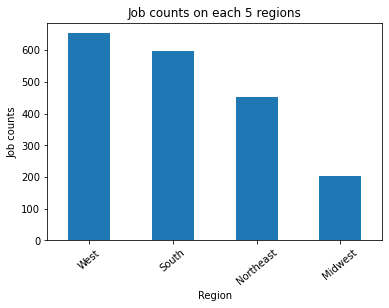

In [2944]:
data.Region.value_counts().plot(kind='bar')
plt.ylabel('Job counts')
plt.xlabel('Region')
plt.xticks(rotation=40)
plt.title('Job counts on each 5 regions')
plt.show()

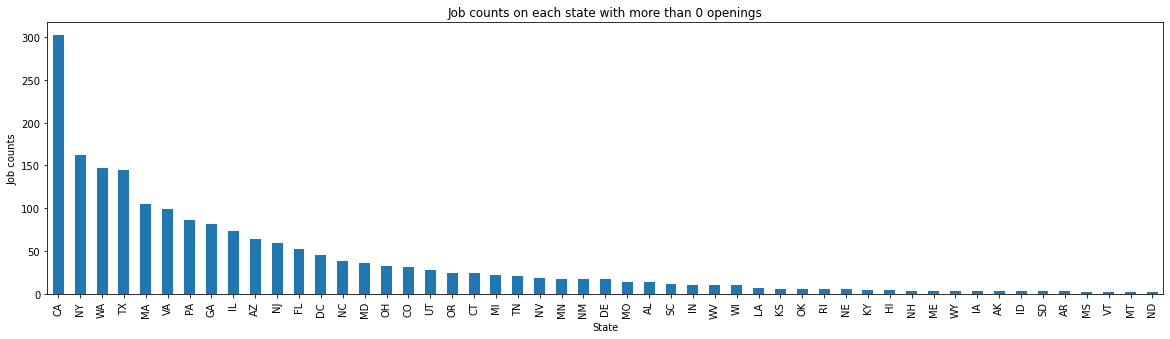

In [2945]:
plt.subplots(figsize=(20, 5))
data.State.value_counts().plot(kind='bar')
plt.ylabel('Job counts')
plt.xlabel('State')
plt.title('Job counts on each state with more than 0 openings')
plt.show()

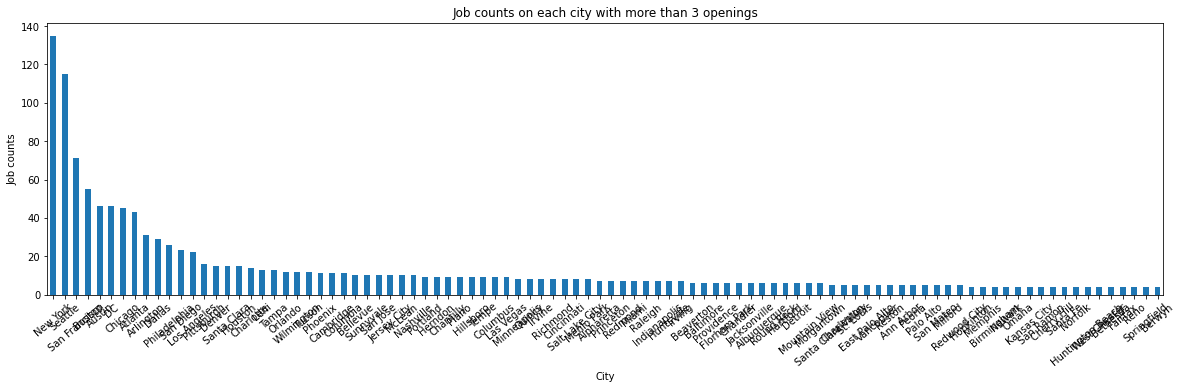

In [2946]:
plt.subplots(figsize=(20, 5))
data.groupby('City').filter(lambda x: len(x) >3 )['City'].value_counts().plot(kind='bar')
plt.xticks(rotation=40)
plt.ylabel('Job counts')
plt.xlabel('City')
plt.title('Job counts on each city with more than 3 openings')
plt.show()     

In [2947]:
data.City.str.contains('Princeton').sum()

7

### Step 6: Create new variables 'isSenior', 'isJunior', and 'isMid' from job Title

In [2948]:
data.JobTitle.unique()

array(['Financial Data Analyst', 'Data Analyst', 'Program Data Analyst',
       ..., 'Assembly & Test Technician (B Shift) - Temp-to-Hire',
       'Market Access Consultant, US Commercial Enablement - Diabetes',
       'Principal Market Access Specialist, US Commercial Enablement - Diabetes'],
      dtype=object)

In [2949]:
# these may not be necessary
#data['JobTitle'] = data['JobTitle'].astype('str')
#type(data.JobTitle[0])

In [2950]:
data['isSenior'] = data.JobTitle.str.contains('Senior|Sr|sr|Director|VP|Lead|Principal')

In [2951]:
data['isJunior'] = data.JobTitle.str.contains('Junior|Jr|jr|Intern')

In [2952]:
data['isMid'] = data.JobTitle.str.contains('Mid Level|Mid-')

In [2953]:
data.loc[:, ['JobTitle','isSenior','isJunior','isMid']].head(3)

,JobTitle,isSenior,isJunior,isMid
0,Financial Data Analyst,False,False,False
1,Data Analyst,False,False,False
2,Program Data Analyst,False,False,False


In [2954]:
data[data.JobTitle.str.contains('Mid Level|Mid-')]

,JobID,JobTitle,Company,Location,CompanyRating,PostDate,ExtractDate,Summary,Salary,Remote,...,JobDetail,JobDescription,DatePosted,isRemote,City,State,Region,isSenior,isJunior,isMid
215,7dcfc088a97ee297,"Metrics & Reporting Analyst (Mid-Career, Level 3)",LOCKHEED MARTIN CORPORATION,"Greenville, SC",4.0,Today,2021-02-26,Coordinate with data stakeholders to resolve d...,NaN,NaN,...,NaN,NaN,2021-02-26,False,Greenville,SC,South,False,False,True


### Step 7: Process Salary data, and create new variables SalaryMidValue and SalaryGroup 

In [2955]:
# string, dict, list appear as Object in df, however, the type can be tested as individual cell
# data.Salary = data.Salary.astype(str) # this cause missing value from NaN to 'nan'
type(data.Salary[0])


float

In [2956]:
# the $ that prevents the substring to be found
data.Salary.str.contains('103,690 ').sum()

0

In [2957]:
data.loc[(data.Salary =='$103,690 - $134,798 a year') & (data.isRemote), 'JobDescription']#.iloc[0]

Series([], Name: JobDescription, dtype: object)

In [2958]:
#data.Salary.unique()

In [2959]:
# To create a new variable 'SalaryUnit'
data['SalaryUnit'] = data.Salary.str.extract('(an hour|a year|a month|a week|per class|a day)', expand = True)
data['SalaryUnit'].unique()

array([nan, 'a year', 'an hour', 'a month'], dtype=object)

In [2962]:
# using regular expression
data.Salary.str.replace('[^0-9-.]','').unique()

array([nan, '105000-155000', '48000-56000', '50-55', '30-45', '30-40',
       '55-75', '60000-70000', '20-23', '15', '80000-90000', '14',
       '67212-143483', '100541-115909', '35-60', '30-35', '58',
       '38000-48000', '45000-55000', '66000-95000', '65000-75000', '11',
       '60-65', '15-16', '52000-55000', '30.67-39.87', '18-21', '16-20',
       '95000', '55000-65000', '60000-80000', '65612', '50459-98572',
       '77488-100739', '15-17', '90000-110000', '46', '60000-130000',
       '80000-95000', '75000', '160000-200000', '100000-120000',
       '57190-273904', '132552-197300', '78000-97000', '78000', '130000',
       '140000-150000', '22.21-26.00', '60-80', '80000-100000', '80000',
       '65000-100000', '35', '122300', '145000-175000', '100000-200000',
       '60000', '130000-140000', '124500-160000', '55-60', '6000',
       '50000', '110500-170000', '122530-159286', '101254-187962',
       '15-51', '137170-168000', '70000-90000', '98680-167659',
       '72151-83650', '35000'

In [2887]:
data.loc[data.Salary.str.contains('\+') == True]

,JobID,JobTitle,Company,Location,CompanyRating,PostDate,ExtractDate,Summary,Salary,Remote,...,JobDescription,DatePosted,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit
1852,1e3264ac58fe4c9c,Director of Business Development-Relationships...,"VISUAL SOFT, INC","Vienna, VA",NaN,Today,2021-02-26,"Visual Soft, Inc is seeking an accomplished an...","$160,000 - $180,000 a year ++",NaN,...,NaN,2021-02-26,False,Vienna,VA,South,True,False,False,a year


In [2963]:
# To create a new variable 'SalaryMidValue' going to contain the mid point value for the arrange of salary
#data['SalaryMidValue'] = data['Salary'].str.replace('an hour|a year|a month|a week|per class|a day','').str.replace('$','').str.replace(',','')

data['SalaryMidValue'] = data.Salary.str.replace('[^0-9-.]','')
data.loc[~data.Salary.isnull(),['Salary','SalaryUnit','SalaryMidValue']].head(4)

,Salary,SalaryUnit,SalaryMidValue
1,"$105,000 - $155,000 a year",a year,105000-155000
2,"$48,000 - $56,000 a year",a year,48000-56000
3,$50 - $55 an hour,an hour,50-55
5,$30 - $45 an hour,an hour,30-45


In [2964]:
data.columns



Index(['JobID', 'JobTitle', 'Company', 'Location', 'CompanyRating', 'PostDate',
       'ExtractDate', 'Summary', 'Salary', 'Remote', 'JobUrl', 'JobDetail',
       'JobDescription', 'DatePosted', 'isRemote', 'City', 'State', 'Region',
       'isSenior', 'isJunior', 'isMid', 'SalaryUnit', 'SalaryMidValue'],
      dtype='object')

In [2966]:
data.iloc[[412,150,1085],[8,21,22]]

,Salary,SalaryUnit,SalaryMidValue
412,$22.21 - $26.00 an hour,an hour,22.21-26.00
150,$30.67 - $39.87 an hour,an hour,30.67-39.87
1085,$56.73 an hour,an hour,56.73


In [2967]:
# Set busniss rule to treat range and Ignore 'Up to' and 'From' 
#data['SalaryMidValue'] = data.SalaryMidValue.str.replace('Up to|From','').str.strip()
#data.SalaryMidValue.unique()

In [2968]:
# Take mid value for range salary
s_df = data.SalaryMidValue.str.split(pat ='-',expand =True)
s_df[1].fillna(s_df[0], inplace=True)

data['SalaryMidValue']  = (s_df[1].astype(float)+s_df[0].astype(float))/2


In [2969]:
data.loc[~data.Salary.isnull(),['Salary','SalaryUnit','SalaryMidValue']].head(4)

,Salary,SalaryUnit,SalaryMidValue
1,"$105,000 - $155,000 a year",a year,130000.0
2,"$48,000 - $56,000 a year",a year,52000.0
3,$50 - $55 an hour,an hour,52.5
5,$30 - $45 an hour,an hour,37.5


In [2970]:
data.loc[data.SalaryMidValue >100000,['Salary','SalaryUnit','SalaryMidValue']].sort_values('SalaryMidValue').tail(10)

,Salary,SalaryUnit,SalaryMidValue
397,"$140,000 - $150,000 a year",a year,145000.0
1796,"$128,078 - $166,502 a year",a year,147290.0
613,"$100,000 - $200,000 a year",a year,150000.0
1151,"$94,163 - $206,840 a year",a year,150501.5
873,"$137,170 - $168,000 a year",a year,152585.0
611,"$145,000 - $175,000 a year",a year,160000.0
370,"$132,552 - $197,300 a year",a year,164926.0
365,"$57,190 - $273,904 a year",a year,165547.0
1852,"$160,000 - $180,000 a year ++",a year,170000.0
321,"$160,000 - $200,000 a year",a year,180000.0


In [2971]:
# Convert hourly rate to Salary based on formula hr * 40 * 52 
data.loc[data.SalaryUnit.str.contains('hour', na=False),'SalaryMidValue'] = data.SalaryMidValue * 40 * 52

In [2972]:
# Convert monthly rate to Salary based on formula mr * 12
data.loc[data.SalaryUnit.str.contains('month', na=False),'SalaryMidValue'] = data.SalaryMidValue * 12

In [2973]:
# Convert weekly rate to Salary based on fomula wr * 52 
data.loc[data.SalaryUnit.str.contains('week', na = False), 'SalaryMidValue'] =data.SalaryMidValue * 52

In [2974]:
# Convert daily rate to Salary based on formula dr * 5 * 52
data.loc[data.SalaryUnit.str.contains('day', na=False),'SalaryMidValue'] = data.SalaryMidValue * 5 * 52

In [2975]:
# Ignore the teaching job
data.loc[data.SalaryUnit.str.contains('class', na=False),'SalaryMidValue'] = np.nan

In [2976]:
print(data.SalaryMidValue.describe())

count       144.000000
mean     100486.926389
std       55770.305256
min       22880.000000
25%       65459.000000
50%       96776.000000
75%      130000.000000
max      416000.000000
Name: SalaryMidValue, dtype: float64


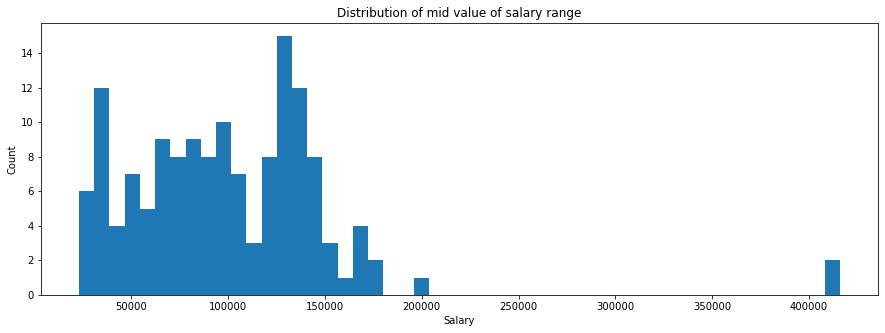

In [2977]:
plt.subplots(figsize = (15,5))
data.SalaryMidValue.plot(kind='hist', bins=50)
plt.xlabel('Salary')
plt.ylabel('Count')
plt.title('Distribution of mid value of salary range')
plt.show()

In [2978]:
# Create SalaryGroup for SalaryMidValue variable
salaryGroupLabels = ['20K-50K','50K-75k','75k-100k','100k-125k','125k+']
salaryRanges =[20000, 50000, 75000, 100000, 125000, np.inf]
data['SalaryGroup'] = pd.cut(data.SalaryMidValue, bins = salaryRanges, labels = salaryGroupLabels)
#data['SalaryGroup'] = pd.qcut(data.SalaryMidValue, q=5, labels = salaryGroupLabels)
data.loc[~data.Salary.isnull(),['Salary','SalaryUnit','SalaryMidValue','SalaryGroup']].head()

,Salary,SalaryUnit,SalaryMidValue,SalaryGroup
1,"$105,000 - $155,000 a year",a year,130000.0,125k+
2,"$48,000 - $56,000 a year",a year,52000.0,50K-75k
3,$50 - $55 an hour,an hour,109200.0,100k-125k
5,$30 - $45 an hour,an hour,78000.0,75k-100k
7,$30 - $40 an hour,an hour,72800.0,50K-75k


In [2979]:
data.SalaryGroup.value_counts().sort_index()

20K-50K      24
50K-75k      26
75k-100k     28
100k-125k    18
125k+        48
Name: SalaryGroup, dtype: int64

In [2980]:
((data.SalaryMidValue <= 125000) & (data.SalaryMidValue > 100000)).sum()

18

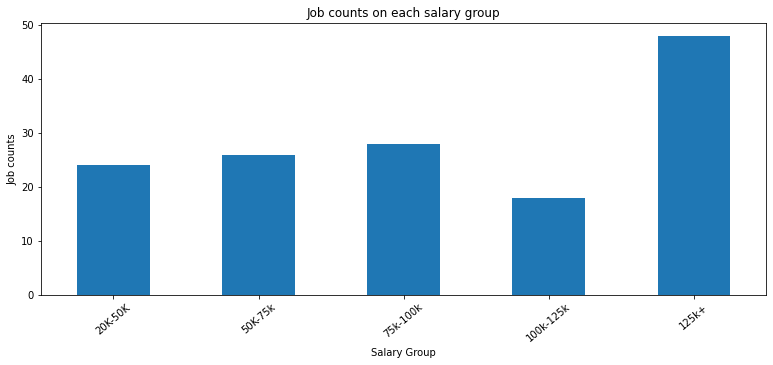

In [2981]:
plt.subplots(figsize=(13,5))
data.SalaryGroup.value_counts(sort=False).plot(kind='bar')
plt.xticks(rotation =40)
plt.xlabel('Salary Group')
plt.ylabel('Job counts')
plt.title('Job counts on each salary group')
plt.show()

In [2615]:
assert data.SalaryMidValue.min() > 10000  

In [2616]:
(data.SalaryMidValue < 100000).sum()

162

In [2617]:
data.SalaryMidValue.isnull().sum()

2092

In [2618]:
data.loc[data.SalaryMidValue > 300000]

,JobID,JobTitle,Company,Location,CompanyRating,PostDate,ExtractDate,Summary,Salary,Remote,...,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit,SalaryMidValue,SalaryGroup


### Step 8: Pandas profiling 

In [2622]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2623]:
# uncomment and run below if you need to pip install the pandas-profiling library
#import sys
#!{sys.executable} -m pip install -U pandas-profiling==2.9.0
#!jupyter nbextension enable --py widgetsnbextension

In [2624]:
from pathlib import Path

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

In [2625]:
report = data.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
report

In [2626]:
profile_report = data.profile_report(html={'style': {'full_width': True}})
profile_report.to_file("../reports/pandas_profiling/{0}_daily.html".format(today))

In [2504]:
#To do list: 
# check missing state  : done ! 
# categorize state: done !
# check dup id : done ! 
# salay categorizing : done!
# remove unneeded columns, save in the interim folder: done!
# run today's data without dedup line in the data collection loop:   done!
# run 2021_02_17 again to fix monthly salary data error: not necessary, since we may not using those data.  done!
# To check detailed description with np.nan value: done!
# make library using package: add project path to sys.path done!
# Try do get more infor from job decription: nothing can be done!
# put it together after a week of trials: done!
# To check the result with new search string in use for more relevence, especially look for salary data: done! 

# find a better way to split Location, to auto treat the case which only contains state information but not ','???
# find a way to create contigency table by using group by instead of crosstab:
# create a log writer

# LOG:
# 2/24/21(W): 4 datasets, second day including 'AI' dataset, first time avg salary above $10k. Start including detailed 
# salary information in the daily file. 
# 2/25/21(TH): 4 datasets.

# Note:
# 1: some big companies could have up to two digits job posting within one day. I can dive deep into analysis on specific 
# company 
# 2: may consider not including data analyst or analytics, ...tried without ','

In [2628]:
data.State.unique()

array(['PA', nan, 'TN', 'MD', 'OH', 'TX', 'WV', 'NC', 'GA', 'DC', 'FL',
       'NY', 'IN', 'CA', 'MI', 'MA', 'NJ', 'MN', 'IL', 'NE', 'UT', 'MO',
       'IA', 'VA', 'AK', 'SC', 'WA', 'CO', 'WI', 'KS', 'PR', 'LA', 'AL',
       'AZ', 'NV', 'OR', 'ID', 'NM', 'AR', 'VT', 'CT', 'KY', 'ND', 'RI',
       'WY', 'OK', 'SD', 'DE', 'HI', 'NH', 'MS', 'ME', 'MT'], dtype=object)

In [2629]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2330 entries, 0 to 2329
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   JobID           2330 non-null   object        
 1   JobTitle        2330 non-null   object        
 2   Company         2330 non-null   object        
 3   Location        2330 non-null   object        
 4   CompanyRating   1895 non-null   float64       
 5   PostDate        2330 non-null   object        
 6   ExtractDate     2330 non-null   datetime64[ns]
 7   Summary         2330 non-null   object        
 8   Salary          238 non-null    object        
 9   Remote          457 non-null    object        
 10  JobUrl          2330 non-null   object        
 11  JobDetail       165 non-null    object        
 12  JobDescription  448 non-null    object        
 13  DatePosted      2330 non-null   datetime64[ns]
 14  isRemote        2330 non-null   bool          
 15  City

### Step 9: Save the dataset in interim folder

In [2630]:
data.shape

(2330, 24)

In [2631]:
# Drop few columns not needed for further analysis
s_data = data.drop(columns = ['PostDate','ExtractDate','Remote', 'JobUrl'])

In [2632]:
s_data.shape

(2330, 20)

In [2633]:
# Add project path
import os
import sys
parent_project_path = os.path.abspath(os.path.join('..'))
if parent_project_path not in sys.path:
    sys.path.append(parent_project_path)


In [2634]:
# save the data to a new csv file

datapath = '../data/interim/'
fileName = '{0}_daily.csv'.format(today)
save_file(s_data, fileName, datapath)

Writing file.  "../data/interim/2021_02_25_daily.csv"


In [2511]:
set(data.loc[data.Company.str.contains('Amazon Dev Center U.S., Inc.',na=False),'JobID']).intersection(id_3)

{'0422fe8200778dbc',
 '0b45b1e572e1acb5',
 '0c1c1fb03d034642',
 '250fac673af5d56e',
 '336c87397051ab0e',
 '3cdef97c29a9ca72',
 '3cef31376293ef0d',
 '68b4930c04a0a5a1',
 '794a4a69e78081ea',
 '7d1c76ca060cd84a',
 '891a32bad15ed2aa',
 '89c1fa946ee99ec7',
 '924892b80ebb4fbf',
 'b7a7d3951ced4974',
 'c84dd74b68f5505a',
 'd2512be3e3e13d3b',
 'd5cdf793ad8fbfc0',
 'e0165c707517e063'}

In [2512]:
data.loc[(data.Company.str.contains('Pearson',na=False)) & (data.State == 'NJ')]

,JobID,JobTitle,Company,Location,CompanyRating,PostDate,ExtractDate,Summary,Salary,Remote,...,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit,SalaryMidValue,SalaryGroup
1315,eaf90bfb3312ddc3,Analytics and Insights Analyst,Pearson,"Trenton, NJ",3.8,Just posted,2021-02-24,Description We are the world’s learning compan...,NaN,Remote,...,True,Trenton,NJ,Northeast,False,False,False,NaN,NaN,NaN


In [2627]:
data.loc[data.Location == 'United States']

,JobID,JobTitle,Company,Location,CompanyRating,PostDate,ExtractDate,Summary,Salary,Remote,...,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit,SalaryMidValue,SalaryGroup
44,19f0387c2f370d8f,Cost and Data Analyst,Ibex Hc Llc,United States,NaN,Today,2021-02-25,"Building Locally, Leading Nationally Top 50 Ho...",NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
282,928d10cb5d8dd78f,Director Collateral Operations,Farm Credit Mid-America,United States,3.8,1 day ago,2021-02-25,Standardize customer communications to resolve...,NaN,NaN,...,False,NaN,NaN,NaN,True,False,False,NaN,NaN,NaN
339,cf7ff47b512b1a55,Data Scientist Apprentice,IBM,United States,3.9,1 day ago,2021-02-25,You will apply the scientific method to busine...,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
340,21ac57c4f1499d84,Data Science Resident,Galvanize Inc.,United States,4.1,Today,2021-02-25,"As part of the Residency program, you will rec...",$35 an hour,NaN,...,False,NaN,NaN,NaN,False,False,False,an hour,72800.0,50K-75k
346,3fc66107e2e3fda5,SOS Data Science Engineer,IBM,United States,3.9,1 day ago,2021-02-25,Optimize data retrieval and develop new dashbo...,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,bea0373a5cdb4e0a,"Associate Partner, SAP S/4 HANA - Electronics",IBM,United States,3.9,1 day ago,2021-02-25,This is a hands-on sales and delivery role.\nR...,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
2083,1495e99efdb35097,SAP Financial Services Associate Partner,IBM,United States,3.9,1 day ago,2021-02-25,"Define, develop and use repeatable non-traditi...",NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
2201,f849ea5778ba35ae,GBSD Sr Principal Engr S/W,Northrop Grumman,United States,4.0,Today,2021-02-25,Design and develop artificial intelligence alg...,NaN,NaN,...,False,NaN,NaN,NaN,True,False,False,NaN,NaN,NaN
2269,d95fd163663ea3a8,"Associate Partner, SAP S/4 HANA - Automotive, ...",IBM,United States,3.9,1 day ago,2021-02-25,Introduction As a Business Sales & Delivery Ex...,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN


## Putting it all together

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Duplicated JobIDs: 422


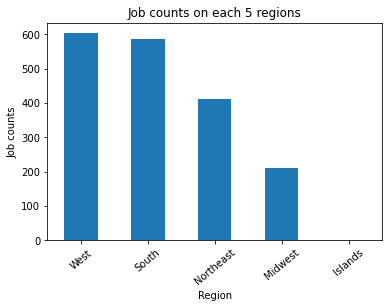

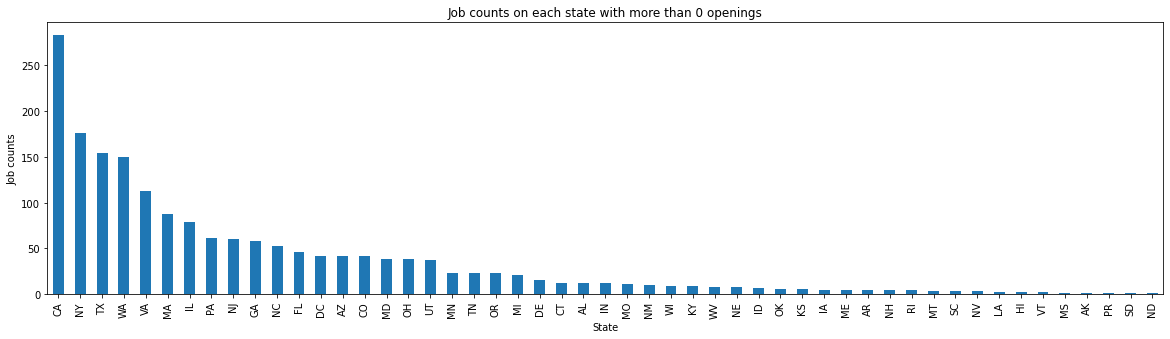

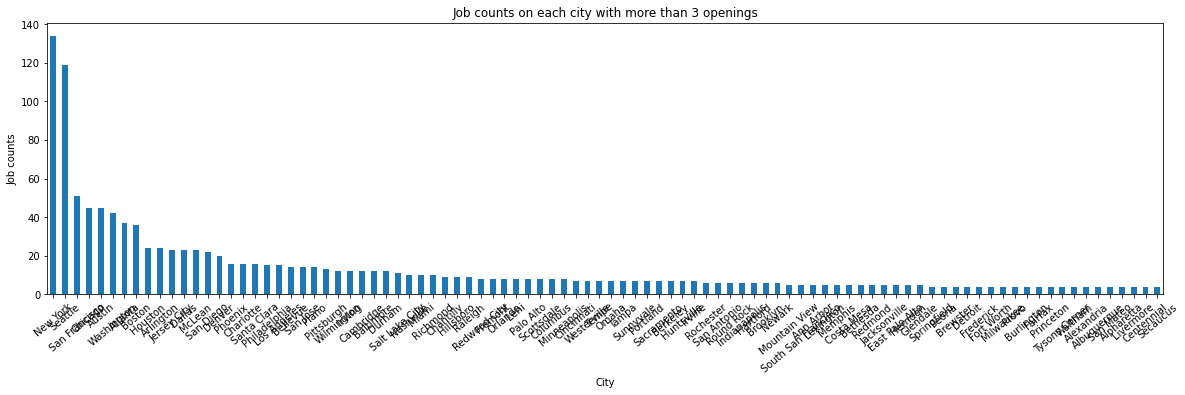

Princeton jobs:  4
count       194.000000
mean      85116.317526
std       42634.283845
min       22880.000000
25%       50000.000000
50%       76675.000000
75%      115000.000000
max      208000.000000
Name: SalaryMidValue, dtype: float64


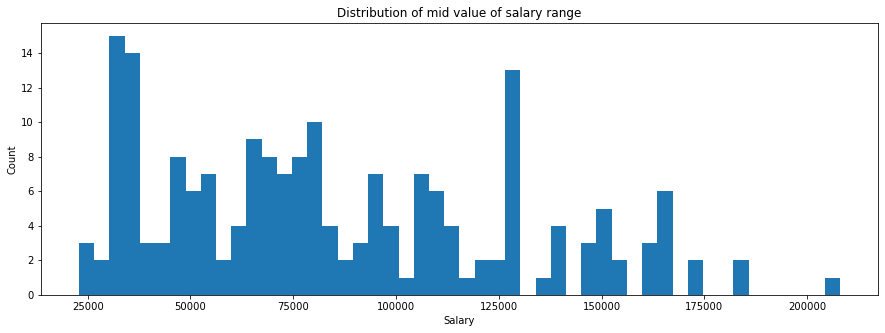

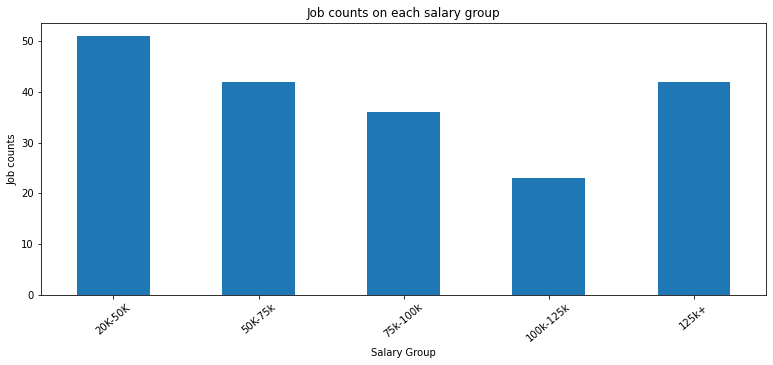

Writing file.  "../data/interim/2021_02_27_daily.csv"


In [2983]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
import os
import sys
from library.sb_utils import save_file

#step 1: To combine 4 datasets into one dataframe
today = datetime.today().strftime('%Y_%m_%d')
dfNames=['da','ds','ml','ai']
data = pd.DataFrame()

for n in dfNames:
    fileName = '../data/raw/{0}_last{1}d_R_{2}.csv'.format(n,'1', today)
    df = pd.read_csv(fileName, skiprows=[0])

    #combine 4 files together
    data = data.append(df, ignore_index=True)
    
#step 2: To de-dup the records in the combined datasets
print("Duplicated JobIDs: " + str(data.duplicated(subset ='JobID').sum()))
data.drop_duplicates(subset = 'JobID', inplace= True)
# To reindex 
data.index = np.arange(0,len(data))

#step 3: To create a new date variable 'DatePosted' by remove the string from 'PostDate' and convert to int
data['DatePosted'] = data.PostDate.str.replace('day ago|days ago','').str.replace('Today|Just posted','0').str.strip().astype(int)
# To convert 'ExtractDate' to datetime type
data['ExtractDate'] = pd.to_datetime(data['ExtractDate'])
# To Convert 'DatePosted' from int to timeDelta type and compute the exact date when the job was posted 
data.DatePosted = pd.to_timedelta(data.DatePosted, unit='D')
data.DatePosted = pd.to_datetime(data['ExtractDate'] - data['DatePosted'])

#step 4: To create a new boolean variable 'isRemote' and assign Ture if varible 'Remote' OR 'Location' is Remote
data['isRemote'] = (data.Remote == 'Remote') | (data.Location =='Remote')

#step 5: To create three new variables City, State and Region
newDf = data.Location.str.split(pat =',',expand =True)
data['City'] = newDf[0]
data['State'] = newDf[1]
# To clean up values of City
data.loc[data.City == 'Remote', 'City'] = np.nan
data.loc[data.City == 'United States', 'City'] = np.nan
# To fill the missing value of 'State' from 'City' for those which has only location of State 
data.State.fillna(data.City, inplace=True)
# To clean up values in 'City'
data.loc[data.State == data.City, 'City'] = np.nan
# To clean up the value of 'Washington DC' on variable 'City'
data.loc[(data.City == 'Washington') & (data.State == 'DC'), 'City'] ='DC'
us_state_abbrev = {'Alabama': 'AL','Alaska': 'AK','American Samoa': 'AS','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT',
    'Delaware': 'DE','District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Guam': 'GU',
    'Hawaii': 'HI', 'Idaho': 'ID','Illinois': 'IL', 'Indiana': 'IN','Iowa': 'IA', 'Kansas': 'KS','Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT', 'Nebraska': 'NE',
    'Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC',
    'North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH', 'Oklahoma': 'OK','Oregon': 'OR', 'Pennsylvania': 'PA',
    'Puerto Rico': 'PR', 'Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN',  'Texas': 'TX','Utah': 'UT',
    'Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI', 'Wyoming': 'WY'
}
# To extract State abbrevation value from City variables to fill those missing values into 'State'
data.loc[data.State.str.len() >3,'State']=data.loc[data.State.str.len() >3,'State'].str.replace(' State','').map(us_state_abbrev)
# To clean up the State values
data.State= data.State.str.strip()

# To categorize state value into 4 regions 
us_state_regions = {'Alabama': 'South','Alaska': 'West','American Samoa': 'Islands',
    'Arizona': 'West','Arkansas': 'South','California': 'West','Colorado': 'West',
    'Connecticut': 'Northeast', 'Delaware': 'South','District of Columbia': 'South','Florida': 'South',
    'Georgia': 'South', 'Guam': 'Islands','Hawaii': 'West',  'Idaho': 'West',
    'Illinois': 'Midwest', 'Indiana': 'Midwest','Iowa': 'Midwest','Kansas': 'Midwest','Kentucky': 'South',
    'Louisiana': 'South','Maine': 'Northeast','Maryland': 'South', 'Massachusetts': 'Northeast',
    'Michigan': 'Midwest','Minnesota': 'Midwest','Mississippi': 'South','Missouri': 'Midwest',
    'Montana': 'West', 'Nebraska': 'Midwest','Nevada': 'West','New Hampshire': 'Northeast', 'New Jersey': 'Northeast',
    'New Mexico': 'West', 'New York': 'Northeast', 'North Carolina': 'South','North Dakota': 'Midwest', 'Northern Mariana Islands':'Islands',
    'Ohio': 'Midwest','Oklahoma': 'South', 'Oregon': 'West','Pennsylvania': 'Northeast','Puerto Rico': 'Islands',
    'Rhode Island': 'Northeast','South Carolina': 'South','South Dakota': 'Midwest','Tennessee': 'South',
    'Texas': 'South','Utah': 'West','Vermont': 'Northeast','Virgin Islands': 'Islands','Virginia': 'South',
    'Washington': 'West','West Virginia': 'South','Wisconsin': 'Midwest','Wyoming': 'West'}
# To create a new variable 'Region' by mapping to the dict
data['Region'] = data.loc[~data.State.isnull(),'State'].map(us_state_regions_mapping).astype('category')

data.Region.value_counts().plot(kind='bar')
plt.ylabel('Job counts')
plt.xlabel('Region')
plt.xticks(rotation=40)
plt.title('Job counts on each 5 regions')
plt.show()

plt.subplots(figsize=(20, 5))
data.State.value_counts().plot(kind='bar')
plt.ylabel('Job counts')
plt.xlabel('State')
plt.title('Job counts on each state with more than 0 openings')
plt.show()

plt.subplots(figsize=(20, 5))
data.groupby('City').filter(lambda x: len(x) >3 )['City'].value_counts().plot(kind='bar')
plt.xticks(rotation=40)
plt.ylabel('Job counts')
plt.xlabel('City')
plt.title('Job counts on each city with more than 3 openings')
plt.show()     

print("Princeton jobs: ",data.City.str.contains('Princeton').sum())

#step 6: To create new variables 'isSenior', 'isJunior','isMid'
data['isSenior'] = data.JobTitle.str.contains('Senior|Sr|sr|Director|VP|Lead|Principal')
data['isJunior'] = data.JobTitle.str.contains('Junior|Jr|jr|Intern')
data['isMid'] = data.JobTitle.str.contains('Mid Level|Mid-')

#step 7: To create new variables 'SalaryUnit', 'SalaryMidValue' and 'SalaryGroup'
# To create a new variable 'SalaryUnit'
data['SalaryUnit'] = data.Salary.str.extract('(an hour|a year|a month|a week|per class|a day)', expand = True)

# To create a new variable 'SalaryMidValue' going to contain the mid point value for the arrange of salary
# Set busniss rule to treat range: take mid value of a range and Ignore 'Up to' and 'From' 
data['SalaryMidValue'] = data.Salary.str.replace('[^0-9-.]','')

# Take mid value for range salary
s_df = data.SalaryMidValue.str.split(pat ='-',expand =True)
s_df[1].fillna(s_df[0], inplace=True)
data['SalaryMidValue']  = (s_df[1].astype(float)+s_df[0].astype(float))/2

# Convert hourly rate to Salary based on formula hr * 40 * 52 
data.loc[data.SalaryUnit.str.contains('hour', na=False),'SalaryMidValue'] = data.SalaryMidValue * 40 * 52
# Convert monthly rate to Salary based on formula mr * 12
data.loc[data.SalaryUnit.str.contains('month', na=False),'SalaryMidValue'] = data.SalaryMidValue * 12
# Convert weekly rate to Salary based on fomula wr * 52 
data.loc[data.SalaryUnit.str.contains('week', na = False), 'SalaryMidValue'] =data.SalaryMidValue * 52
# Convert daily rate to Salary based on formula dr * 5 * 52
data.loc[data.SalaryUnit.str.contains('day', na=False),'SalaryMidValue'] = data.SalaryMidValue * 5 * 52
# Ignore the teaching job
data.loc[data.SalaryUnit.str.contains('class', na=False),'SalaryMidValue'] = np.nan

print(data.SalaryMidValue.describe())
plt.subplots(figsize = (15,5))
data.SalaryMidValue.plot(kind='hist', bins=50)
plt.xlabel('Salary')
plt.ylabel('Count')
plt.title('Distribution of mid value of salary range')
plt.show()

# Create variable 'SalaryGroup'
salaryGroupLabels = ['20K-50K','50K-75k','75k-100k','100k-125k','125k+']
salaryRanges =[20000, 50000, 75000, 100000, 125000, np.inf]
data['SalaryGroup'] = pd.cut(data.SalaryMidValue, bins = salaryRanges, labels = salaryGroupLabels)

plt.subplots(figsize=(13,5))
data.SalaryGroup.value_counts(sort=False).plot(kind='bar')
plt.xticks(rotation =40)
plt.xlabel('Salary Group')
plt.ylabel('Job counts')
plt.title('Job counts on each salary group')
plt.show()

#step 8: To create a profile and save to the reports folder
profile_report = data.profile_report(html={'style': {'full_width': True}})
profile_report.to_file("../reports/pandas_profiling/{0}_daily.html".format(today))

#step 9: Save the processed df into inter
# Drop few columns not needed for further analysis
s_data = data.drop(columns = ['PostDate','ExtractDate','Remote', 'JobUrl'])
# Add project path
parent_project_path = os.path.abspath(os.path.join('..'))
if parent_project_path not in sys.path:
    sys.path.append(parent_project_path)
# save the data to a new csv file
datapath = '../data/interim/'
fileName = '{0}_daily.csv'.format(today)
save_file(s_data, fileName, datapath)

